In [9]:
from math import sin, pi, fabs
import numpy as np
from matplotlib import pyplot as plt
from random import random, seed

%matplotlib inline

In [10]:
# SIMULATION PARAMETERS
simulation_length = 10
dt = 1 / 100
seed(25)

# GlOBAL VARIABLES
current_time = 0
position = 0
velocity = 0
x = np.array([
    [0],
    [0]
])
P = np.diag([0.2, 1.2])
Q = np.array([
    [0.001, 0.1],
    [0.1, 0.001]
])

R = np.array([[4.]])

graph_data = {
    "time_stamps": [],
    "accelerations": [],
    "positions": [],
    "velocities": [],
    
    "imu_accelerations": [],
    "altimeter_height": [],
    
    "x_bar_pos": [],
    "x_bar_vel": [],
    
    "predicted_positions": [],
    "predicted_velocities": [],
}

while True:
    
    current_time += dt
    
    # physics (Calculate expected values)
    acc = 5 * sin((2 * pi / 10) * current_time) + 5  # expected acceleration
    position += velocity * dt + 0.5 * acc * dt * dt  # expected position
    velocity += acc * dt  # expected velocity
    
    # simulate sensors
    acc_imu = acc + 0.2  * (2 * random() - 1)  # measured acceleration
    pos_alt = position + 2 * (2 * random() - 1)  # measured position
    
    # kalman filter!!
    
    F = np.array([
        [1, dt],
        [0, 1]
    ])
    
    B = np.array([
        [0.5 * dt * dt],
        [dt]
    ])
    
    # x = Fx + Bu
    x_bar = F @ x + B * acc_imu
    
    graph_data["x_bar_pos"].append(x_bar[0])
    graph_data["x_bar_vel"].append(x_bar[1])
    
    # P = FPF' + Q
    P = F @ P @ F.T + Q
    
    H = np.array([[1, 0]])

    # y = z - Hx
    y = np.array([[pos_alt]]) - H @ x_bar

    # S = HPH' + R
    S = H @ P @ H.T + R

    # K = PH'inv(S)
    K = P @ H.T @ np.linalg.inv(S)
    
    # P = (I - KH)P
    P = P - K @ H @ P
    
    x = x_bar + K @ y
        
    # save data
    
    graph_data["time_stamps"].append(current_time)
    graph_data["accelerations"].append(acc)
    graph_data["velocities"].append(velocity)
    graph_data["positions"].append(position)
    
    graph_data["imu_accelerations"].append(acc_imu)
    graph_data["altimeter_height"].append(pos_alt)

    graph_data["predicted_positions"].append(x[0])
    graph_data["predicted_velocities"].append(x[1])
        
    if current_time > simulation_length:
        break

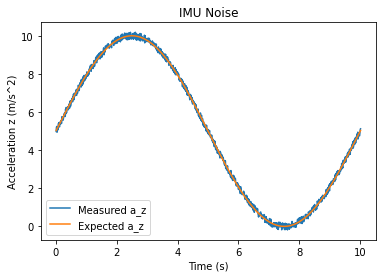

In [11]:
plt.title("IMU Noise")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration z (m/s^2)")

plt.plot(graph_data["time_stamps"], graph_data["imu_accelerations"], label='Measured a_z')
plt.plot(graph_data["time_stamps"], graph_data["accelerations"], label='Expected a_z')
plt.legend(loc='lower left')

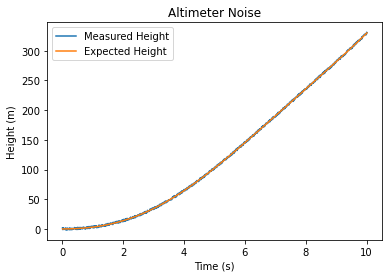

In [12]:
plt.title("Altimeter Noise")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")

plt.plot(graph_data["time_stamps"], graph_data["altimeter_height"], label='Measured Height')
plt.plot(graph_data["time_stamps"], graph_data["positions"], label='Expected Height')
plt.legend(loc='upper left')

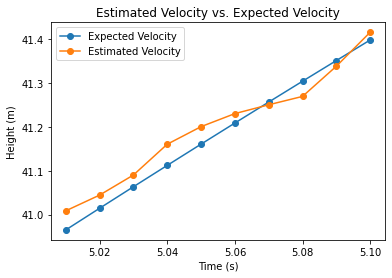

In [13]:
start = 500
points = 10
end = start + points

plt.title("Estimated Velocity vs. Expected Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")

plt.plot(graph_data["time_stamps"][start:end], graph_data["velocities"][start:end], marker='o', label='Expected Velocity')
plt.plot(graph_data["time_stamps"][start:end], graph_data["predicted_velocities"][start:end], marker='o', label='Estimated Velocity')

plt.legend(loc='upper left')

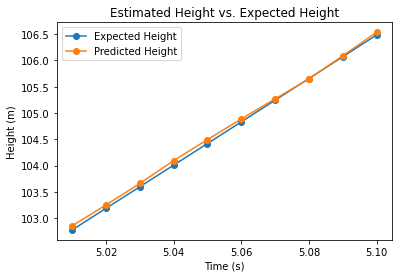

In [14]:
start = 500
points = 10
end = start + points
m = 'o' if points < 20 else ''

plt.title("Estimated Height vs. Expected Height")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")

plt.plot(graph_data["time_stamps"][start:end], graph_data["positions"][start:end], marker=m, label='Expected Height')
plt.plot(graph_data["time_stamps"][start:end], graph_data["predicted_positions"][start:end], marker=m, label='Predicted Height')

plt.legend(loc='upper left')

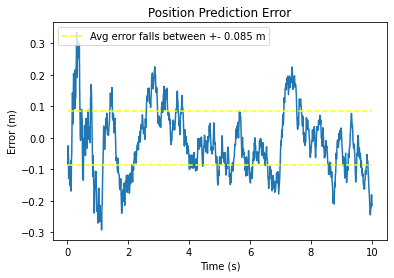

In [15]:
errors = [graph_data["positions"][x] - graph_data["predicted_positions"][x] for x in range(len(graph_data["positions"]))]
error_mags = [fabs(e) for e in errors]

avg = sum(errors) / len(errors)
avg_mag = sum(error_mags) / len(error_mags)

plt.title("Position Prediction Error")
plt.xlabel("Time (s)")
plt.ylabel("Error (m)")

plt.plot(graph_data["time_stamps"], errors)
plt.plot(graph_data["time_stamps"], [avg_mag for x in graph_data["time_stamps"]], linestyle='--', color='yellow', label=f'Avg error falls between +- {round(avg_mag, 3)} m')
plt.plot(graph_data["time_stamps"], [-avg_mag for x in graph_data["time_stamps"]], linestyle='--', color='yellow')

plt.legend(loc='upper left')

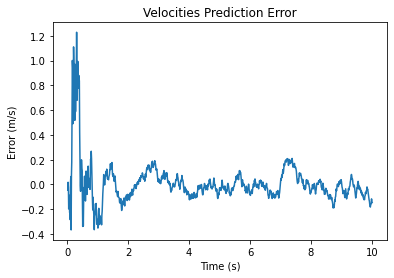

In [16]:
errors = [graph_data["velocities"][x] - graph_data["predicted_velocities"][x] for x in range(len(graph_data["velocities"]))]
avg = sum(errors) / len(errors)

plt.title("Velocities Prediction Error")
plt.xlabel("Time (s)")
plt.ylabel("Error (m/s)")

plt.plot(graph_data["time_stamps"], errors)